In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('./data/house/train.csv')
test_df = pd.read_csv('./data/house/test.csv')

combine = [train_df,test_df]

In [71]:
train_ID = train_df['Id']
test_ID = test_df['Id']

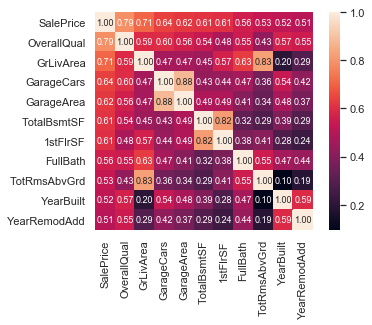

In [4]:
#saleprice correlation matrix
k = 11 #number of variables for heatmap
cols = train_df.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [5]:
# 根据相关性和实际指标分析，选择变量
cols_train = ['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
cols_test = ['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']

In [6]:
df_train = train_df[cols_train]
df_test = test_df[cols_test]

combine = [df_train,df_test]

In [7]:
print(df_train.info())
print('--'*8)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
SalePrice      1460 non-null int64
OverallQual    1460 non-null int64
GrLivArea      1460 non-null int64
GarageCars     1460 non-null int64
TotalBsmtSF    1460 non-null int64
FullBath       1460 non-null int64
YearBuilt      1460 non-null int64
dtypes: int64(7)
memory usage: 79.9 KB
None
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 6 columns):
OverallQual    1459 non-null int64
GrLivArea      1459 non-null int64
GarageCars     1458 non-null float64
TotalBsmtSF    1458 non-null float64
FullBath       1459 non-null int64
YearBuilt      1459 non-null int64
dtypes: float64(2), int64(4)
memory usage: 68.5 KB
None


In [8]:
df_test.fillna(0,inplace=True)

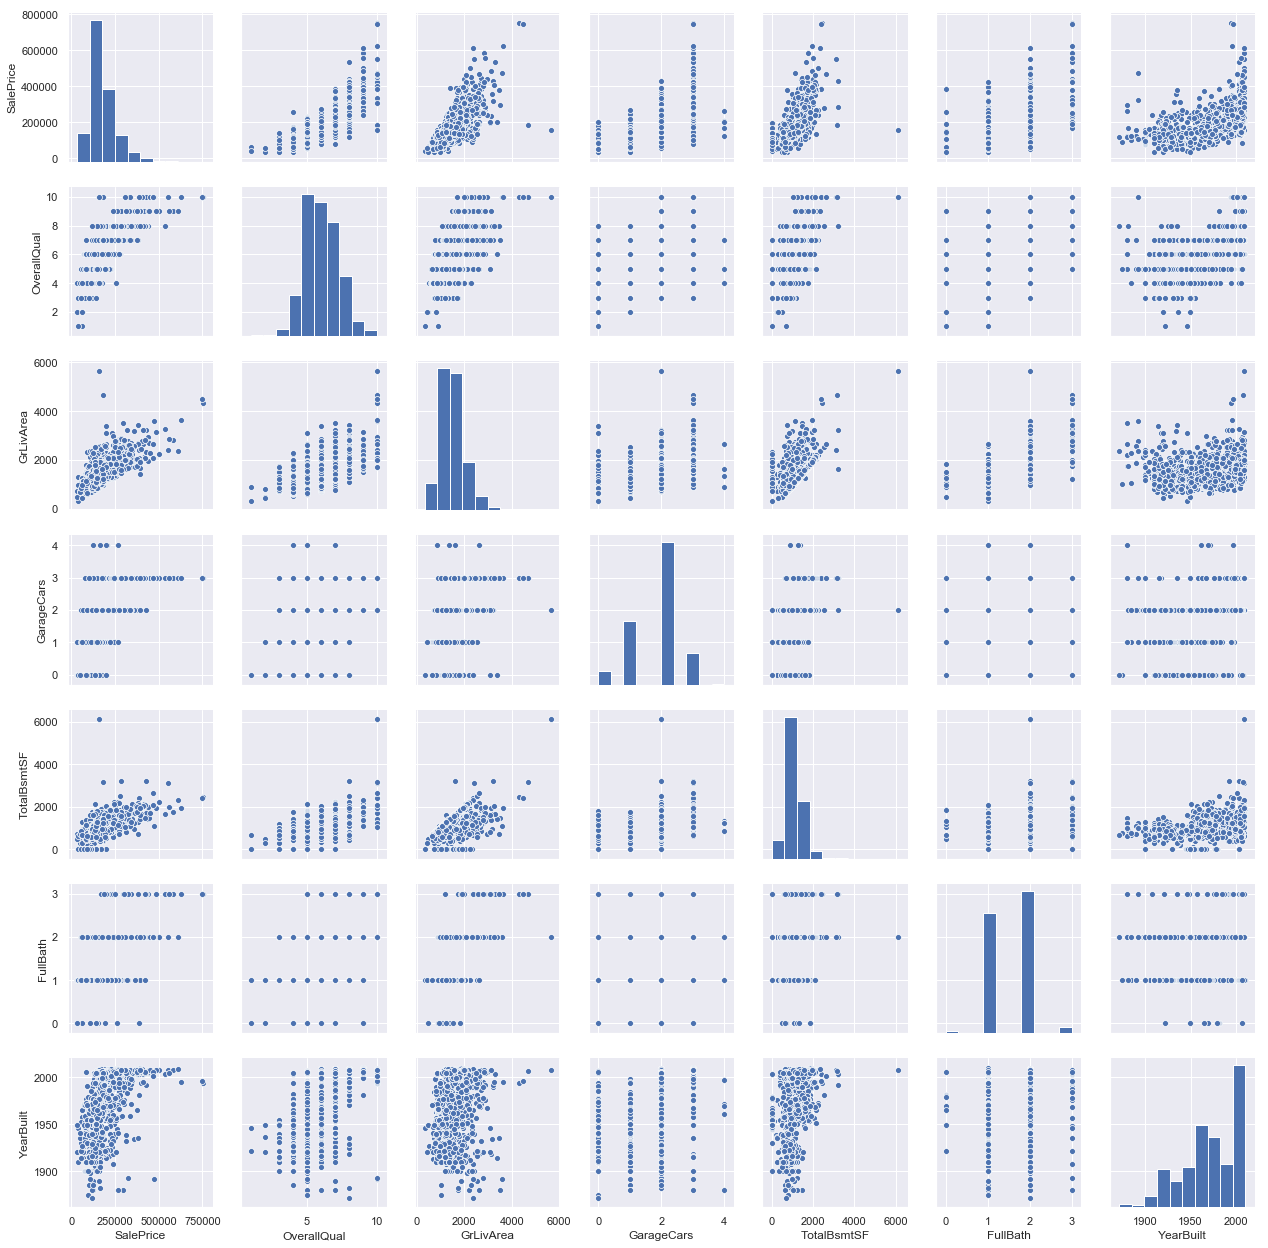

In [9]:
#scatterplot
sns.set()
sns.pairplot(df_train,size = 2.5)
plt.show();

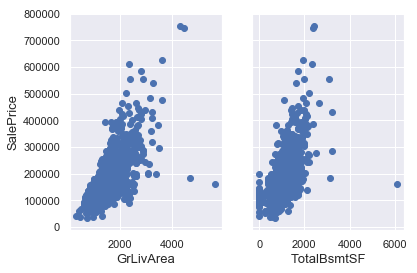

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True)
ax1.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
ax2.scatter(x=df_train['TotalBsmtSF'],y=df_train['SalePrice'])
ax1.set_ylabel('SalePrice', fontsize=13)
ax1.set_xlabel('GrLivArea', fontsize=13)
ax2.set_xlabel('TotalBsmtSF', fontsize=13)
plt.show()

In [11]:
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)
df_train = df_train.query('TotalBsmtSF<4000')

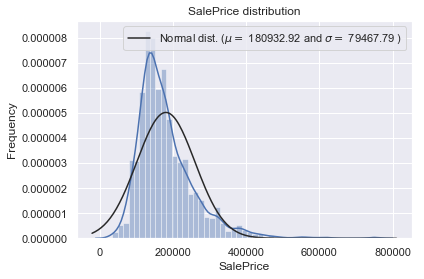

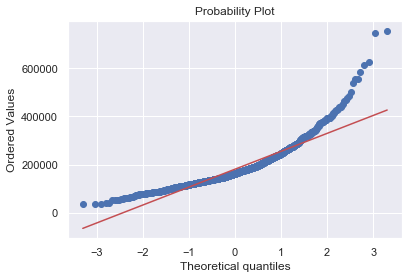

In [12]:
sns.distplot(df_train['SalePrice'] , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

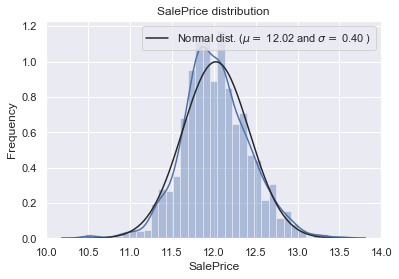

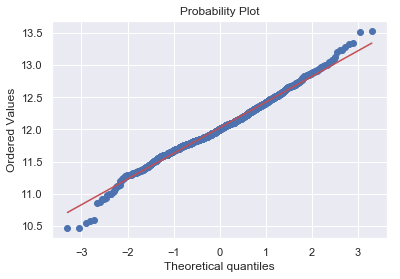

In [13]:
#applying log transformation    
df_train['SalePrice'] = np.log1p(df_train['SalePrice']) # log(1+x)
#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(df_train['SalePrice'])
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

开始建模

In [14]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [48]:
x_train = df_train.drop('SalePrice',axis=1)
y_train = df_train['SalePrice'].values

K-fold 交叉验证

In [49]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

基本模型

In [16]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)) # 异常值敏感
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [50]:
acc_lasso = rmsle_cv(lasso).mean()
acc_ENet = rmsle_cv(ENet).mean()
acc_KRR = rmsle_cv(KRR).mean()
acc_GBoost = rmsle_cv(GBoost).mean()
acc_xgb = rmsle_cv(model_xgb).mean()
acc_lgb = rmsle_cv(model_lgb).mean()

In [51]:
models = pd.DataFrame({
    'Model': ['Lasso Regression', 'ElasticNet Regression', 'KernelRidge Regression', 
              'Gradient Boosting Regression', 'XGBoosting', 'LightGBM'],
    'Score': [acc_lasso, acc_ENet, acc_KRR, acc_GBoost, acc_xgb, acc_lgb]})
models.sort_values(by='Score')

,Model,Score
2,KernelRidge Regression,0.154990
4,XGBoosting,0.155886
1,ElasticNet Regression,0.156387
0,Lasso Regression,0.156390
5,LightGBM,0.158017
3,Gradient Boosting Regression,0.164119


stacking models

In [24]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [54]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1522 (0.0046)



adding a meta-model

In [26]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

To make the two approaches comparable (by using the same number of models) , we just average Enet KRR and Gboost, then we add lasso as meta-model.

In [60]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1526 (0.0043)


In [56]:
stacked_averaged_models = StackingAveragedModels(base_models = (lasso, GBoost, KRR),
                                                 meta_model = ENet)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1526 (0.0043)


In [57]:
stacked_averaged_models = StackingAveragedModels(base_models = (lasso, ENet,KRR),
                                                 meta_model = GBoost)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1648 (0.0064)


In [59]:
stacked_averaged_models = StackingAveragedModels(base_models = (lasso, GBoost, ENet),
                                                 meta_model = KRR)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1531 (0.0047)


In [61]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [63]:
averaged_models.fit(x_train.values, y_train)
aver_train_pred = averaged_models.predict(x_train.values)
aver_pred = np.expm1(averaged_models.predict(df_test.values))
print(rmsle(y_train, train_pred))

0.13327309834151074


In [64]:
model_xgb.fit(x_train, y_train)
xgb_train_pred = model_xgb.predict(x_train)
xgb_pred = np.expm1(model_xgb.predict(df_test))
print(rmsle(y_train, xgb_train_pred))

0.1247600038311792


In [65]:
model_lgb.fit(x_train, y_train)
lgb_train_pred = model_lgb.predict(x_train)
lgb_pred = np.expm1(model_lgb.predict(df_test.values))
print(rmsle(y_train, lgb_train_pred))

0.14613334895564534


In [67]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,aver_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.13201974746906703


In [68]:
ensemble = aver_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [70]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


In [72]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('houseprice_pred.csv',index=False)